In [92]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pyautogui
from PIL import Image 
from Xlib import display
import numpy as np
import matplotlib.pyplot as plt
import time
from mss.linux import MSS as mss
import mss.tools
import cv2

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import segmentation_models_pytorch as smp

import os


In [73]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["villager"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 3

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [74]:
model = torch.load("models/model.pth", map_location = "cpu")

In [75]:
mini_transforms = transforms.Compose([ 
                                                                    
                                    transforms.ToPILImage(),
                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                    ToTensor(),

                                ])

In [76]:
def screen_record_efficient(top = 225, left = 0, width = 800, height = 100):
  
    mon = {"top": top, "left": left, "width": width, "height": height}
    sct = mss.mss()
    img = np.array(sct.grab(mon))
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    sct.close()
    return img

In [77]:
def find_blobs_return_vertices(thresh_image, minimum_size = 50, padding = 20):

    rect_vertices = []
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if 0 in (x,y,w,h): ## skip invali stuff 
            continue
        if w < minimum_size or h < minimum_size :  # skip if too small to be a worm
            continue
        w += padding 
        h+= padding 
        rect_vertices.append([(x - padding , y - padding ), (x+w, y+h)])
    return rect_vertices

def draw_rectangle(image, vertex1, vertex2):
    image = cv2.rectangle(image,
                    vertex1,
                    vertex2,
                    color=(0, 255, 0), thickness=3)
    return image

In [111]:
def test_model_and_visualize(image_paths, model):
    overlays = []
    for path in image_paths:
        image = cv2.imread(path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        inp = mini_transforms(image).unsqueeze(0)
        pred = model(inp).detach().numpy()[0][0]

        pred[pred <= 0.99] = 0
    
        edged = cv2.Canny((pred*255).astype(np.uint8), 30, 200) 
        contours, hierarchy = cv2.findContours(edged,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

        overlay = cv2.resize(image,(256,256)) 
        
        cv2.drawContours(overlay, contours, -1, (0, 255, 255), 3) 
        overlays.append(overlay)

    return overlays

In [112]:
paths = ["test_images/" + i for i in os.listdir("test_images")]

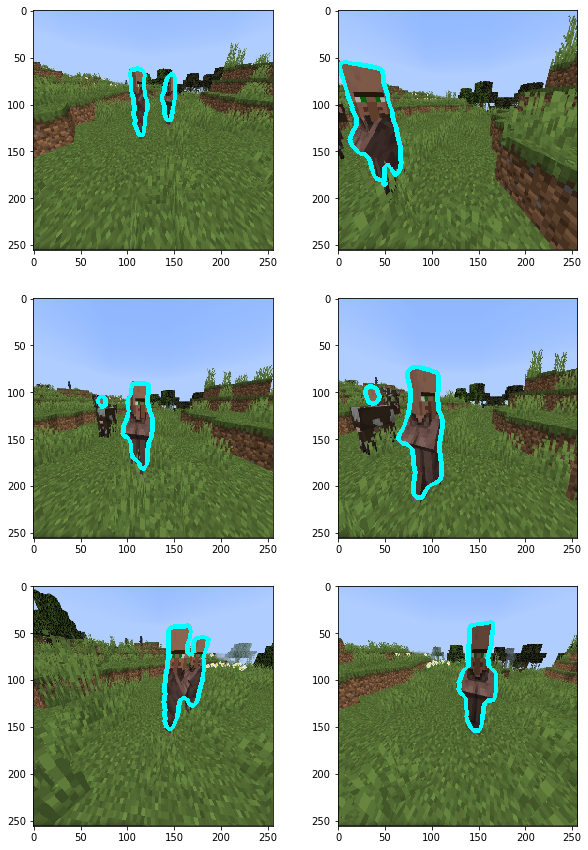

In [116]:
overlays = test_model_and_visualize(paths, model)

fig, ax = plt.subplots(3,2, figsize = (10,15))

for i in range(len(overlays)):
    ax.flat[i].imshow(overlays[i])
    

In [80]:
dual_monitor_top = 1080 + 35
single_monitor_top = 35 + 30

In [89]:
while True:
    foo = screen_record_efficient(top = single_monitor_top,width = 800, height = 510)
    
    inp = mini_transforms(foo).unsqueeze(0)
    pred = model(inp).detach().numpy()[0][0]
#     print(pred.shape)
    
#     cv2.imshow("im", cv2.resize(foo, (256,256)))   

    pred[pred <= 0.5] = 0
    
    edged = cv2.Canny((pred*255).astype(np.uint8), 30, 200) 
    contours, hierarchy = cv2.findContours(edged,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

    
    overlay = cv2.resize(foo,(256,256)) 
    
    cv2.drawContours(overlay, contours, -1, (0, 255, 255), 3) 

    cv2.imshow("im",overlay)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
        
cv2.destroyAllWindows()
    